## Dimensionality reduction
We are interested in assessing how different dimensionality reduction techniques impact our cluster analyses.

1. Apply PCA and (if your computer's resources allow) another dimensionality reduction technique to visualize the data.
2. Change the parameters of the dimensionality reduction techniques (in particular, the number of components) to generate different latent spaces and assess how they impact cluster analysis. For this, select the best clustering algorithm that you identified in Assignment 01, and group samples together using the different latent spaces.
3. Compare each latent space in terms of its ability to group samples according to their tissue of origin.


### Load data

In [2]:
# import packages
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
import umap 
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [3]:
# import data from 01_preprocessing jupyter notebook
GTEx_data = pd.read_pickle("../GTEx_data_input.pkl")
GTEx_labels = pd.read_pickle("../GTEx_labels.pkl")

### Visualize data using PCA and UMAP

#### PCA Visualizations

In [4]:
from sklearn.decomposition import PCA
# reduce GTEx data to a PCA of 50 dimensions
pca = PCA(n_components=50)
pca_fit = pca.fit(GTEx_data)
X = pca_fit.transform(GTEx_data)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(GTEx_labels)
y_lan = le.transform(GTEx_labels)

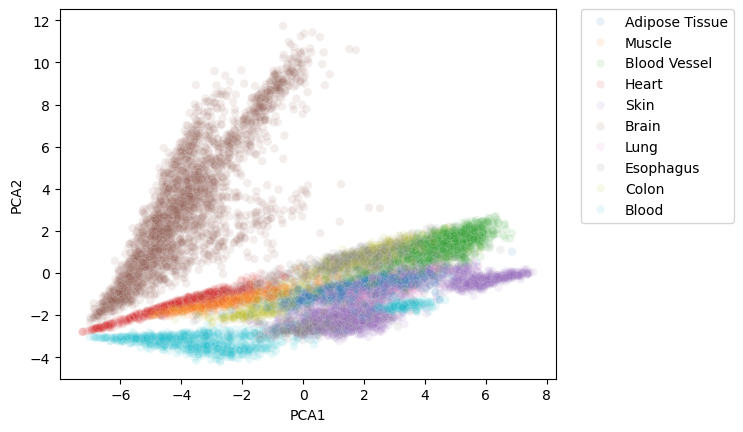

In [5]:
pca_df = pd.DataFrame({
    "PCA1": X[:, 0],
    "PCA2": X[:, 1],
    "Tissue": GTEx_labels,
    "label": y_lan
})
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="Tissue", data=pca_df, alpha = 0.1)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Do I have enough components?
Let's do something similar to the elbow method...

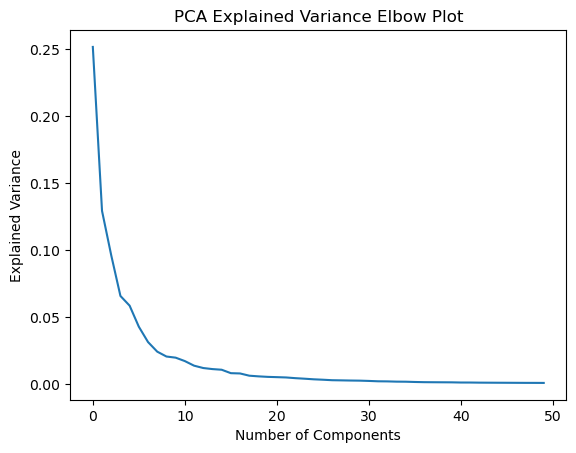

In [6]:
plt.plot(pca_fit.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance Elbow Plot')
plt.show()


By 10 PCA components, I'm explaining most of the variation in the data. 

#### UMAP Visualizations

In [7]:
# reduce data with UMAP, set seed because stochastic
reducer = umap.UMAP(random_state=42, n_components=2)
embedding = reducer.fit_transform(GTEx_data)

/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


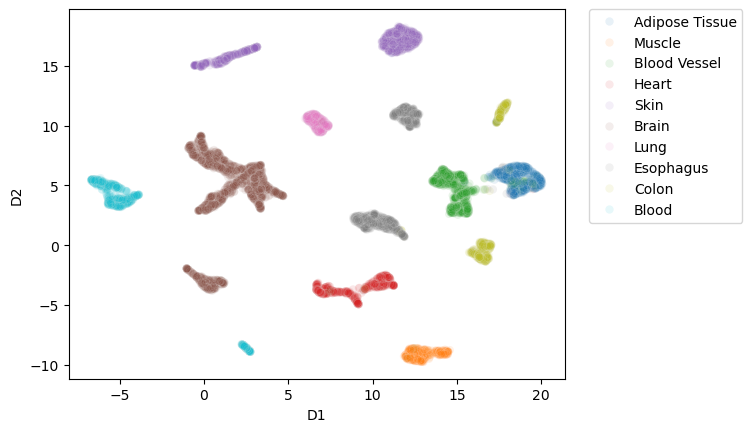

In [8]:
umap_df = pd.DataFrame({
    "D1": embedding[:, 0],
    "D2": embedding[:, 1],
    "Tissue": GTEx_labels,
    "label": y_lan
})
ax = sns.scatterplot(x="D1", y="D2", hue="Tissue", data=umap_df, alpha = 0.1)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

There is much clearer separation of the types using UMAP when compared to the PCA.

### Dimension Reduction and Clustering

- Compare PCA n_components on clustering
- Compare umap n_neighbors on clustering (seems more interesting than n_components)
- Compare PCA > umap on clustering 

In [9]:
# PCA n_components on clustering analysis
# Define ranges for PCA components and clusters
Ks = range(10, 21, 5)
n_components_list = range(10, 51, 10)
# Initialize an empty list to store results
results = []

In [10]:
# Loop through PCA components
for n_components in n_components_list:
    
    # Fit PCA with the current number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(GTEx_data)
    
    # Loop through different numbers of clusters
    for k in Ks:
        model = cluster.AgglomerativeClustering(n_clusters=k, linkage="ward", )
        part = model.fit_predict(X_pca)  # Predict using PCA-transformed data
        
        # Compute performance metrics
        ari_score = ari(part, y_lan)
        ami_score = ami(part, y_lan)

        # Append results as a dictionary
        results.append({
            "n_components": n_components,
            "k_clusters": k,
            "ARI": ari_score,
            "AMI": ami_score
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

    n_components  k_clusters       ARI       AMI
0             10          10  0.544191  0.719991
1             10          15  0.558635  0.764221
2             10          20  0.580246  0.790516
3             20          10  0.557374  0.765238
4             20          15  0.642020  0.823306
5             20          20  0.601933  0.811545
6             30          10  0.510377  0.732655
7             30          15  0.631925  0.812704
8             30          20  0.601223  0.803766
9             40          10  0.511197  0.718735
10            40          15  0.644198  0.812159
11            40          20  0.549907  0.790573
12            50          10  0.491281  0.714188
13            50          15  0.637160  0.814733
14            50          20  0.589958  0.792296


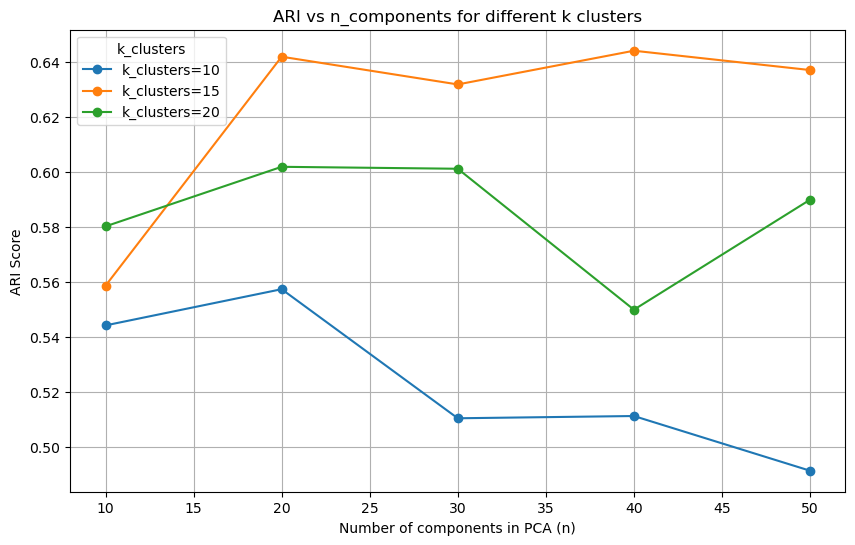

In [11]:
# plot results

# Group by `n_components` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_components"], group["ARI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("ARI vs n_components for different k clusters")
plt.xlabel("Number of components in PCA (n)")
plt.ylabel("ARI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

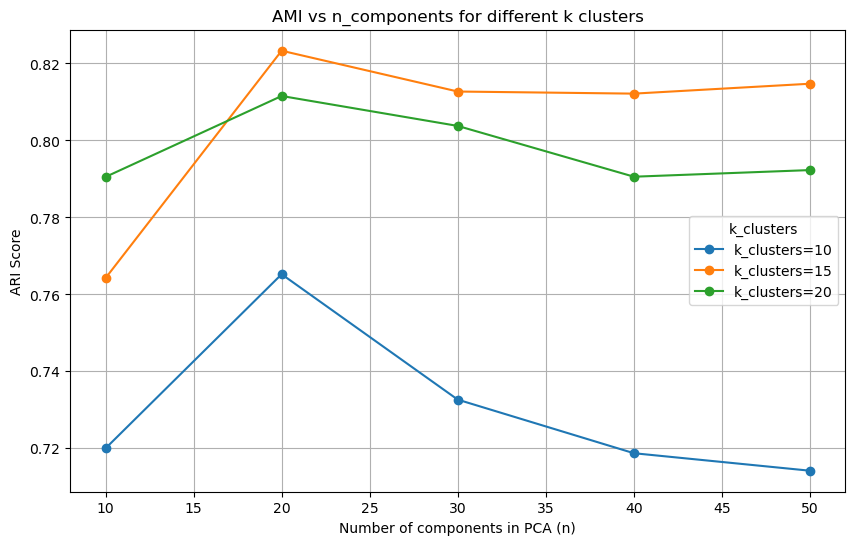

In [12]:
# Group by `n_components` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_components"], group["AMI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("AMI vs n_components for different k clusters")
plt.xlabel("Number of components in PCA (n)")
plt.ylabel("ARI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

Interestingly, 20 components appears to work better than adding additional components. The best k_clusters continues to be 15, similar to last time. 

In [13]:
# UMAP n_neighbors on clustering analysis
# Define ranges for umap neighbors and clusters
Ks = range(10, 21, 5)
n_neighbors_list = (10, 20, 50, 100, 200)
# Initialize an empty list to store results
results = []

In [14]:
# Loop through Umap neighbors
for n_neighbor in n_neighbors_list:
    # Fit UMAP with the current number of neighbors
    # set seed because UMAP stochastic
    reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=n_neighbor)
    X_umap = reducer.fit_transform(GTEx_data)
    
    # Loop through different numbers of clusters
    for k in Ks:
        model = cluster.AgglomerativeClustering(n_clusters=k, linkage="ward")
        part = model.fit_predict(X_umap)  # Predict using UMAP-transformed data
        
        # Compute performance metrics
        ari_score = ari(part, y_lan)
        ami_score = ami(part, y_lan)

        # Append results as a dictionary
        results.append({
            "n_neighbor": n_neighbor,
            "k_clusters": k,
            "ARI": ari_score,
            "AMI": ami_score
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/projects/kterwelp@xsede.o

    n_neighbor  k_clusters       ARI       AMI
0           10          10  0.734798  0.851142
1           10          15  0.703950  0.869347
2           10          20  0.608638  0.842515
3           20          10  0.681653  0.839635
4           20          15  0.705219  0.871612
5           20          20  0.610546  0.841660
6           50          10  0.696722  0.845126
7           50          15  0.737588  0.892802
8           50          20  0.614035  0.843960
9          100          10  0.703566  0.856169
10         100          15  0.719923  0.873624
11         100          20  0.588882  0.828262
12         200          10  0.683325  0.839106
13         200          15  0.705432  0.863833
14         200          20  0.606297  0.837224


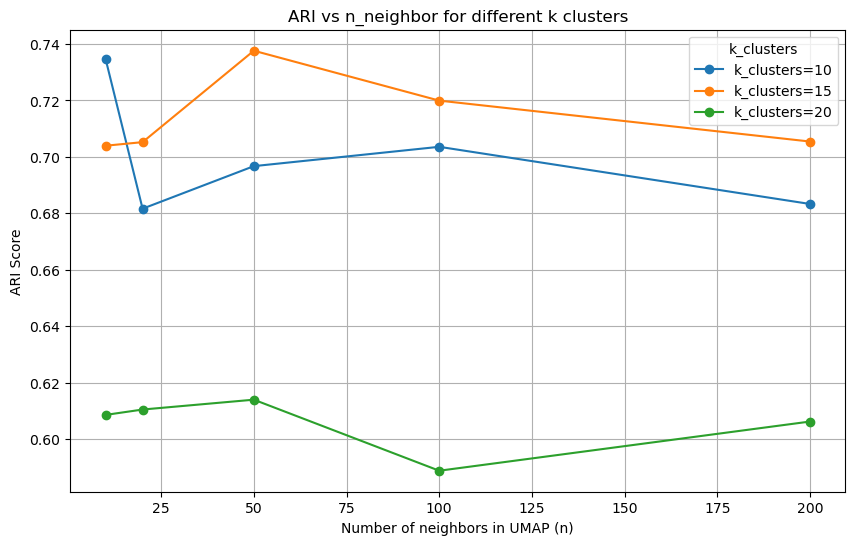

In [15]:
# plot results

# Group by `n_neighbors` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_neighbor"], group["ARI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("ARI vs n_neighbor for different k clusters")
plt.xlabel("Number of neighbors in UMAP (n)")
plt.ylabel("ARI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

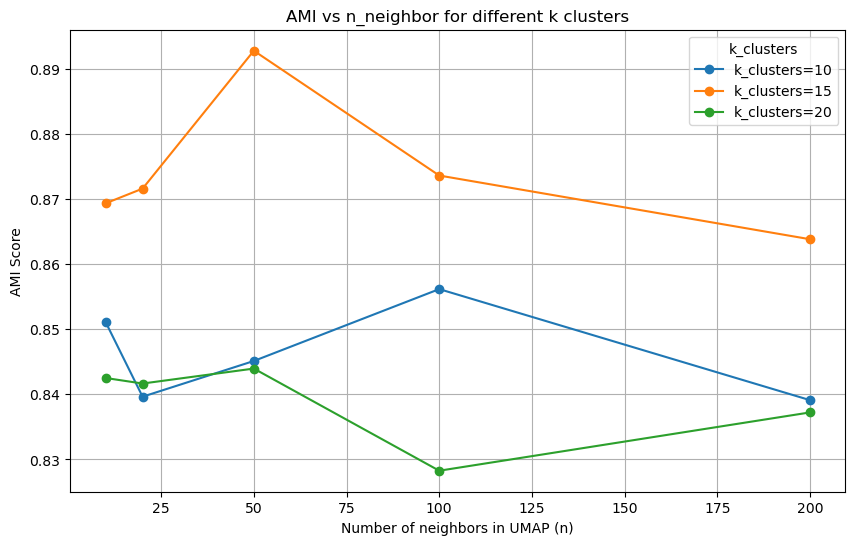

In [16]:
# plot results

# Group by `n_neighbors` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_neighbor"], group["AMI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("AMI vs n_neighbor for different k clusters")
plt.xlabel("Number of neighbors in UMAP (n)")
plt.ylabel("AMI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

Interestingly, 50 neighbors with 15 clusters appears to be the best. However, this depends on the number of k clusters. 

I've seen that people run PCA first and then UMAP to help with the high dimensional problem... wonder if doing that would improve cluster accuracy? 


In [17]:
# UMAP on differing PCA latent spaces comparison
# PCA n_components on clustering analysis
# Define ranges for PCA components and clusters
Ks = range(10, 21, 5)
n_components_list = range(10, 51, 10)
# Initialize an empty list to store results
results = []

In [18]:
# Loop through PCA components
for n_components in n_components_list:
    
    # Fit PCA with the current number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(GTEx_data)
    # Fit UMAP to PCA
    reducer = umap.UMAP(random_state=42, n_components=2)
    X_umap = reducer.fit_transform(X_pca)
    # Loop through different numbers of clusters
    for k in Ks:
        model = cluster.AgglomerativeClustering(n_clusters=k, linkage="ward")
        part = model.fit_predict(X_umap)  # Predict using PCA-transformed data
        
        # Compute performance metrics
        ari_score = ari(part, y_lan)
        ami_score = ami(part, y_lan)

        # Append results as a dictionary
        results.append({
            "n_components": n_components,
            "k_clusters": k,
            "ARI": ari_score,
            "AMI": ami_score
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/projects/kterwelp@xsede.o

    n_components  k_clusters       ARI       AMI
0             10          10  0.648393  0.815988
1             10          15  0.658620  0.843682
2             10          20  0.580545  0.815022
3             20          10  0.644265  0.828023
4             20          15  0.690264  0.865496
5             20          20  0.577166  0.815182
6             30          10  0.639097  0.827595
7             30          15  0.666097  0.850474
8             30          20  0.614361  0.840345
9             40          10  0.697815  0.845860
10            40          15  0.746386  0.894291
11            40          20  0.622771  0.846627
12            50          10  0.697756  0.845250
13            50          15  0.682428  0.855335
14            50          20  0.616436  0.841804


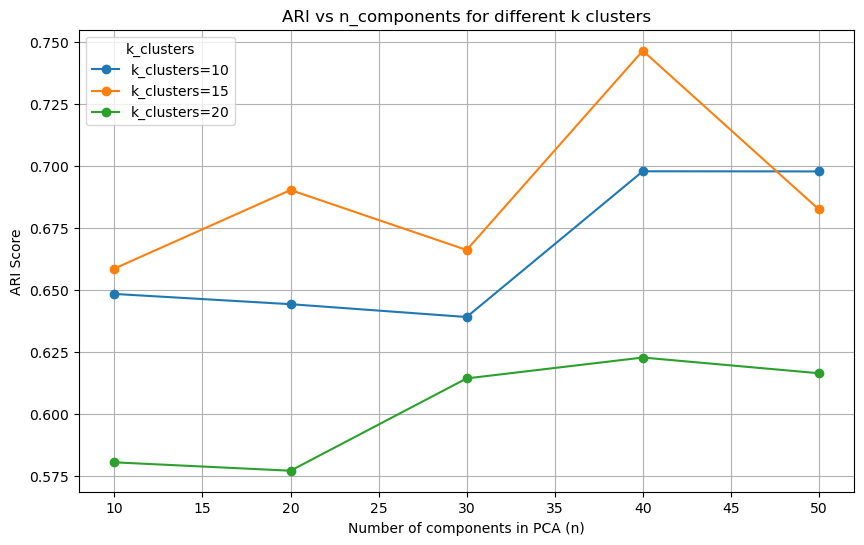

In [19]:
# plot results

# Group by `n_components` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_components"], group["ARI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("ARI vs n_components for different k clusters")
plt.xlabel("Number of components in PCA (n)")
plt.ylabel("ARI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

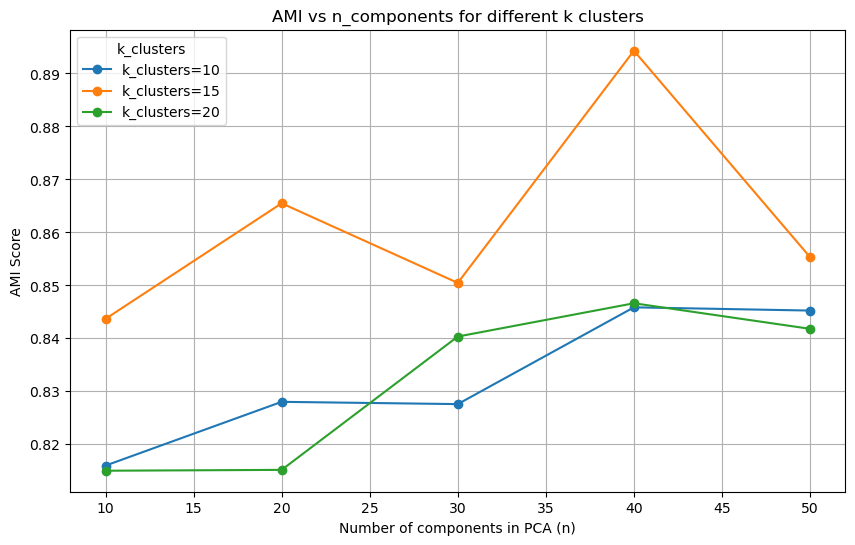

In [20]:
# Group by `n_components` and plot each group
plt.figure(figsize=(10, 6))

for k_clusters, group in results_df.groupby("k_clusters"):
    plt.plot(group["n_components"], group["AMI"], marker='o', label=f'k_clusters={k_clusters}')

plt.title("AMI vs n_components for different k clusters")
plt.xlabel("Number of components in PCA (n)")
plt.ylabel("AMI Score")
plt.legend(title="k_clusters")
plt.grid(True)
plt.show()

It looks a little worse than just using UMAP without PCA. It does improve PCA performance...

The best latent space looks to be UMAP. Let's try to optimize this further. 

In [5]:
# UMAP altering min_dist, n_neighbors, and n_components
# Define ranges for parameters
n_components_list = (200, 300, 500, 2000) 
# Initialize an empty list to store results
results = []

In [6]:
for n_component in n_components_list:
    # using best n_neighbors = 50, and n_clusters = 15 from previous plots 
    reducer = umap.UMAP(random_state=42, n_components=n_component, n_neighbors=50)
    X_umap = reducer.fit_transform(GTEx_data)
    model = cluster.AgglomerativeClustering(n_clusters=15, linkage="ward")
    part = model.fit_predict(X_umap)  # Predict using UMAP-transformed data
        
    # Compute performance metrics
    ami_score = ami(part, y_lan)
        
            
    # Append results as a dictionary
    results.append({
    "n_component": n_component,
    "AMI": ami_score
    })
            
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/projects/kterwelp@xsede.o

   n_component       AMI
0          200  0.896955
1          300  0.892404
2          500  0.876020
3         2000  0.816433


In [7]:
min_dist_list = (0.1, 0.15, 0.2, 0.25)
# Initialize an empty list to store results
results = []

In [8]:
for min_dist in min_dist_list:
    # using best n_neighbors = 50, and n_clusters = 15, and n_components of 200 from previous plots 
    reducer = umap.UMAP(random_state=42, n_components=200, n_neighbors=50, min_dist=min_dist)
    X_umap = reducer.fit_transform(GTEx_data)
    model = cluster.AgglomerativeClustering(n_clusters=15, linkage="ward")
    part = model.fit_predict(X_umap)  # Predict using UMAP-transformed data
        
    # Compute performance metrics
    ami_score = ami(part, y_lan)
        
            
    # Append results as a dictionary
    results.append({
        "min_dist": min_dist,
        "AMI": ami_score
                })
            
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/projects/kterwelp@xsede.o

   min_dist       AMI
0      0.10  0.896955
1      0.15  0.873920
2      0.20  0.866181
3      0.25  0.893965
